# Imports

In [38]:
import requests
import numpy as np
import pandas as pd
import os
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm

# Config

In [75]:
cnf = OmegaConf.create()

cnf.datasets_path = "../datasets"
cnf.download_url = "https://query1.finance.yahoo.com/v7/finance/download/SBUX?period1=1576063151&period2=1607685551&interval=1d&events=history&includeAdjustedClose=true"
cnf.save_path = os.path.join(cnf.datasets_path, "SBUX.csv")

cnf.input_size = 5
cnf.hidden_size = 2
cnf.num_layers = 1
cnf.output_size = 1
cnf.fcn_layers = [cnf.hidden_size, 256, 128, cnf.output_size]

cnf.num_epochs = 2000
cnf.learning_rate = np.exp(-8).item()

# Donwload the Dataset

In [11]:
# download the dataset from https://query1.finance.yahoo.com/v7/finance/download/SBUX?period1=1576063151&period2=1607685551&interval=1d&events=history&includeAdjustedClose=true
# to ../datasets


with open(cnf.save_path, "wb") as f:
    f.write(
        requests.get(cnf.download_url, headers={"User-Agent": "Mozilla/5.0"}).content
    )

# Load the Dataset

In [12]:
df = pd.read_csv(cnf.save_path, index_col="Date", parse_dates=True)
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.370247,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,80.855171,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.276833,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.377647,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,80.781860,7296900


<Axes: title={'center': 'Star Bucks Stock Volume'}, xlabel='Date'>

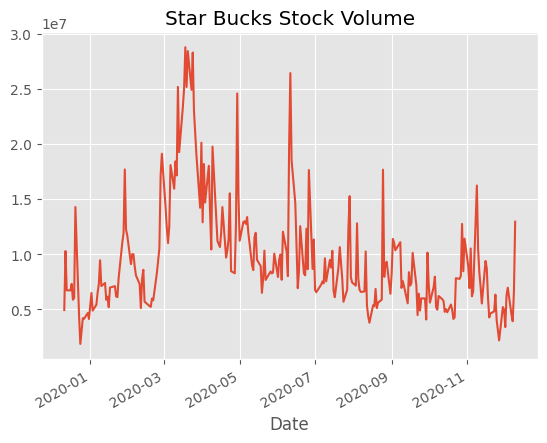

In [14]:
plt.style.use("ggplot")
df["Volume"].plot(label="CLOSE", title="Star Bucks Stock Volume")

# Data Preprocessing

In [23]:
X = df.iloc[:, :-1]  # take all columns except the last one
y = df.iloc[:, -1:]  # take the last column

Since this is not an article focused on different techniques of data preprocessing, you will use StandardScaler for the features, and MinMaxScaler (to scale values between 0 and 1) for the output values. Notice that it is a regression problem, so it is very beneficial to scale your outputs otherwise you will be dealing with a huge loss.

In [26]:
mm = MinMaxScaler()
ss = StandardScaler()

In [27]:
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

This will transform and scale the dataset. The next thing is splitting the dataset into 2 parts. 1 is for the training, and the other part is for testing the values. Since it is sequential data, and order is important, you will use the last 20% of the data for testing.

In [30]:
# TODO: train-test split (without shuffling)
X_train = None
X_test = None
y_train = None
y_test = None

In [31]:
# reshaping to rows, timestamps, features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [32]:
# convert to torch tensors
# Variable is used to allow automatic differentiation

X_train = Variable(torch.Tensor(X_train).float())
X_test = Variable(torch.Tensor(X_test).float())

y_train = Variable(torch.Tensor(y_train).float())
y_test = Variable(torch.Tensor(y_test).float())

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([202, 1, 5]),
 torch.Size([51, 1, 5]),
 torch.Size([202, 1]),
 torch.Size([51, 1]))

# Model

In [76]:
class LSTMNet(nn.Module):
    def __init__(self, cnf):
        super(LSTMNet, self).__init__()

        self.cnf = cnf

        self.lstm = nn.LSTM(
            input_size=self.cnf.input_size,
            hidden_size=self.cnf.hidden_size,
            num_layers=self.cnf.num_layers,
            batch_first=True,  # for some reason (legacy code probably), LSTM doesn't expect the batch size as the first dimension
            # so we need to set this to True
        )

        self.fcn = nn.Sequential()
        for x, y in zip(self.cnf.fcn_layers[:-1], self.cnf.fcn_layers[1:]):
            self.fcn.add_module("fcn_{}".format(x), nn.Linear(x, y))
            self.fcn.add_module("relu_{}".format(y), nn.ReLU())

    def forward(self, x):
        # initial hidden and cell states
        h_0 = Variable(
            torch.zeros(self.cnf.num_layers, x.size(0), self.cnf.hidden_size)
        )
        c_0 = Variable(
            torch.zeros(self.cnf.num_layers, x.size(0), self.cnf.hidden_size)
        )

        # forward propagation
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # output is a tensor containing the output features (h_t)
        # from the LSTM for each t in the input sequence.

        # hn is a tensor containing the final hidden state for each
        # element in the input. If the LSTM has multiple layers,
        # it contains the final hidden state for each layer.

        # cn is a tensor containing the final cell state for
        # each element in the input. If the LSTM has multiple layers,
        # it contains the final cell state for each layer.

        # Reshape output to fit the fully connected layer input
        out = output.contiguous().view(-1, self.cnf.hidden_size)
        out = self.fcn(out)

        return out

In [77]:
model = LSTMNet(cnf)

In [78]:
criterion = torch.nn.MSELoss()  # mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr=cnf.learning_rate)

# Training

In [79]:
for epoch in range(cnf.num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.11269935965538025
Epoch: 100, Loss: 0.023238511756062508
Epoch: 200, Loss: 0.017346177250146866
Epoch: 300, Loss: 0.01690860278904438
Epoch: 400, Loss: 0.016589073464274406
Epoch: 500, Loss: 0.016242749989032745
Epoch: 600, Loss: 0.01572718471288681
Epoch: 700, Loss: 0.01455287728458643
Epoch: 800, Loss: 0.013235639780759811
Epoch: 900, Loss: 0.011865382082760334
Epoch: 1000, Loss: 0.01100336667150259
Epoch: 1100, Loss: 0.010600285604596138
Epoch: 1200, Loss: 0.010352944023907185
Epoch: 1300, Loss: 0.01012667827308178
Epoch: 1400, Loss: 0.009910610504448414
Epoch: 1500, Loss: 0.009746241383254528
Epoch: 1600, Loss: 0.009615086019039154
Epoch: 1700, Loss: 0.009508296847343445
Epoch: 1800, Loss: 0.009393260814249516
Epoch: 1900, Loss: 0.009298368357121944


# Testing

But before performing predictions on the whole dataset, you’ll need to bring the original dataset into the model suitable format, which can be done by using similar code as above.

In [80]:
df_X_ss = ss.transform(df.iloc[:, :-1])  # old transformers
df_y_mm = mm.transform(df.iloc[:, -1:])  # old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss))  # converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

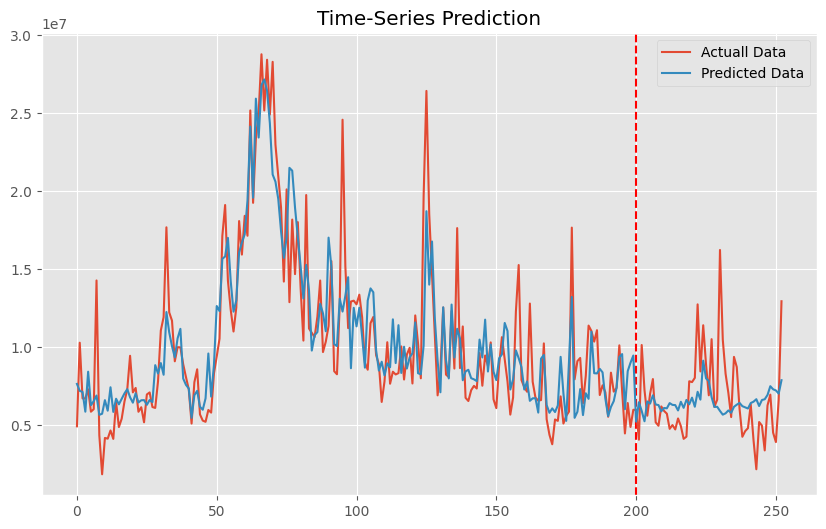

In [81]:
train_predict = model(df_X_ss)  # forward pass
data_predict = train_predict.data.numpy()  # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict)  # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10, 6))  # plotting
plt.axvline(x=200, c="r", linestyle="--")  # size of the training set

plt.plot(dataY_plot, label="Actuall Data")  # actual plot
plt.plot(data_predict, label="Predicted Data")  # predicted plot
plt.title("Time-Series Prediction")
plt.legend()
plt.show()